Note: If running on Google Colab, make sure to create a data/ folder and src/ folder in the runtime with all of the necessary sub-folders and files. Something like this:

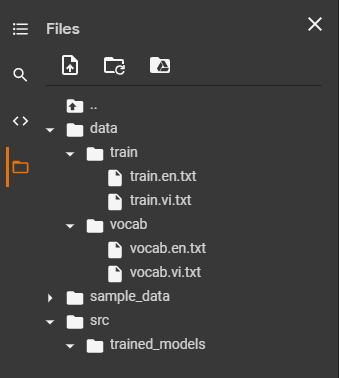


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

import time
import math
import os

In [ ]:
class EnVietDataset(Dataset):
    def __init__(self, en_path, viet_path, en_vocab_path, viet_vocab_path):
        super().__init__()

        en_inputs = []
        viet_translations = []

        with open(en_path, 'r', encoding='utf-8') as en_f:
            for en_line in en_f.readlines():
                en_sequence = en_line.strip()
                en_tokens = en_sequence.split(' ')
                en_tokens.insert(0, '<s>')
                en_tokens.append('</s>')
                en_inputs.append(en_tokens)

        with open(viet_path, 'r', encoding='utf-8') as viet_f:
            for viet_line in viet_f.readlines():
                viet_sequence = viet_line.strip()
                viet_tokens = viet_sequence.split(' ')
                viet_tokens.insert(0, '<s>')
                viet_tokens.append('</s>')
                viet_translations.append(viet_tokens)

        # Vocab maps english tokens to indices then reverse vocab maps indices to english tokens
        en_vocab = self._build_vocab(en_vocab_path)
        en_reverse_vocab = {index: token for token, index in en_vocab.items()}

        # Vocab maps vietnamese tokens to indices then reverse vocab maps indices to vietnamese tokens
        viet_vocab = self._build_vocab(viet_vocab_path)
        viet_reverse_vocab = {index: token for token, index in viet_vocab.items()}

        self.en_vocab = en_vocab
        self.en_reverse_vocab = en_reverse_vocab

        self.viet_vocab = viet_vocab
        self.viet_reverse_vocab = viet_reverse_vocab

        indexed_en_inputs = [self.tokens_to_indices(en_input, lang='en') for en_input in en_inputs]
        indexed_viet_translations = [self.tokens_to_indices(viet_translation, lang='viet') for viet_translation in viet_translations]

        self.en_inputs = indexed_en_inputs
        self.viet_translations = indexed_viet_translations

    def __getitem__(self, index):
        return self.en_inputs[index], self.viet_translations[index]

    def __len__(self):
        return len(self.en_inputs)

    @staticmethod
    def _build_vocab(vocab_path):
        """Builds a vocab (dictionary) of word->index.

        Args:
            vocab_path (str): Path to the vocab.

        Returns:
            dict of word->index: The vocab of word->index.
        """
        assert os.path.exists(vocab_path)

        vocab = {'<pad>': 0}
        token_id = 1

        with open(vocab_path, 'r', encoding='utf-8') as f:
            for line in f.readlines():
                token = line.strip()
                vocab[token] = token_id
                token_id += 1

        return vocab

    def tokens_to_indices(self, tokens, lang='en'):
        """Converts a list of tokens from strings to their corresponding indices in the specified vocab.

        Args:
            tokens (list of str's): Tokens to be converted.
            lang (str, optional): Specifies which vocab to use. Defaults to 'en' for English. Other option
            is 'viet' for Vietnamese.

        Returns:
            length-N tensor: Tensor containing the indices corresponding to each token.
        """
        assert lang == 'en' or lang == 'viet'

        indices = []
        vocab = self.en_vocab if lang == 'en' else self.viet_vocab

        unk_token = vocab['<unk>']

        for token in tokens:
            indices.append(vocab.get(token, unk_token))

        return torch.tensor(indices)

    def indices_to_tokens(self, indices, lang='en'):
        """Converts indices to tokens and concatenates them as a string.

        Args:
            indices (list of str's): A tensor of indices (with shape (N, 1) or length-N), a list of (1, 1) tensors,
            or a list of indices (ints).
            lang (str, optional): Specifies which vocab to use. Defaults to 'en' for English. Other option
            is 'viet' for Vietnamese.

        Returns:
            str: String from concatenating the tokens.
        """
        assert lang == 'en' or lang == 'viet'

        tokens = []
        reverse_vocab = self.en_reverse_vocab if lang == 'en' else self.viet_reverse_vocab

        for index in indices:
            if torch.is_tensor(index):
                index = index.item()
            token = reverse_vocab.get(index, '<unk>')
            if token == '<pad>':
                continue
            tokens.append(token)

        return " ".join(tokens)

def collate_fn(batch):
    """Create a batch of data given a list of N input sequences and output sequences. Returns a tuple
    containing two tensors each with shape (N, max_sequence_length), where max_sequence_length is the
    maximum length of any sequence in the batch.

    Args:
        batch (list): A list of size N, where each element is a tuple containing two sequence tensors.

    Returns:
        tuple of two tensors, list of ints, list of ints: A tuple containing two tensors each with
    shape (N, max_sequence_length), list of each input sequence's length, and list of each target
    sequence's length.
    """
    en_inputs, viet_translations = zip(*batch)
    max_en_input_length = 0
    max_viet_translation_length = 0

    e = []
    v = []
    e_lens = []
    v_lens = []

    for en_input in en_inputs:
        en_input_length = list(en_input.size())[0]
        e_lens.append(en_input_length)
        if en_input_length > max_en_input_length:
            max_en_input_length = en_input_length
    for en_input in en_inputs:
        en_input_length = list(en_input.size())[0]
        if en_input_length < max_en_input_length:
            e.append(torch.cat((en_input, torch.zeros(max_en_input_length - en_input_length, dtype=int))))
        else:
            e.append(en_input)

    for viet_translation in viet_translations:
        viet_translation_length = list(viet_translation.size())[0]
        v_lens.append(viet_translation_length)
        if viet_translation_length > max_viet_translation_length:
            max_viet_translation_length = viet_translation_length
    for viet_translation in viet_translations:
        viet_translation_length = list(viet_translation.size())[0]
        if viet_translation_length < max_viet_translation_length:
            v.append(torch.cat((viet_translation, torch.zeros(max_viet_translation_length - viet_translation_length, dtype=int))))
        else:
            v.append(viet_translation)

    return (torch.stack(e), torch.stack(v)), e_lens, v_lens

In [ ]:
class AttnEncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
        self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=1, batch_first=True)

    def forward(self, batch_sequences, seq_lens):
        """Forward pass through the encoder.

        Args:
            batch_sequences (N-by-seq_len tensor): Batch containing N length-seq_len tensors
        (e.g., the sequences to be translated). N is the batch size.
            seq_lens (list of ints): List of sequences lengths of each batch element.

        Returns:
            tuple of one (N, seq_len, hidden_size) tensor and two (1, N, hidden_size) tensors: All hidden states of each
            sequence in the batch and (hn, cn) from the RNN (LSTM) layer.
        """
        batch_sequences = self.embedding(batch_sequences)    # N-by-seq_len-by-embedding_dim

        packed_batch_sequences = nn.utils.rnn.pack_padded_sequence(batch_sequences, lengths=seq_lens, batch_first=True, enforce_sorted=False)

        out, (hn, cn) = self.rnn(packed_batch_sequences)    # hn and cn are both 1-by-N-by-hidden_size

        # Unpack output from RNN (LSTM) layer. out_padded is N-by-seq_len-by-hidden_size
        out_padded, _ = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)

        # out_padded: all hidden states of each sequence in the batch
        # hn: the final hidden state of each sequence in the batch
        # cn: final cell state of each sequence in the batch
        return out_padded, hn, cn

class AttnDecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
        self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, prev_outputs, prev_hn, prev_cn, encoder_hidden_states, device):
        """Forward pass through the decoder.

        Args:
            prev_outputs (N-by-1): The ouputs from the previous time step. N is the batch size.
            prev_hn (1-by-N-by-hidden_size tensor):
            prev_cn (1-by-N-by-hidden_size tensor):
            encoder_hidden_states (N-input_seq_len-by-hidden_size tensor):

        Returns:
            tuple of one (N, vocab_size) tensor and two (1, N, hidden_size) tensors: The predicted outputs and (hn, cn) from
        the RNN (LSTM) layer.
        """
        embeddings = self.embedding(prev_outputs)    # N-by-1-by-embedding_dim
        out, (hn, cn) = self.rnn(embeddings, (prev_hn, prev_cn))    # out is N-by-1-by-hidden_size, hn and cn are both 1-by-N-by-hidden_size

        alignment_scores = torch.sum(encoder_hidden_states * out, dim=2, keepdim=True)    # N-by-input_seq_len-by-1

        context_vectors = torch.sum(encoder_hidden_states * alignment_scores, dim=1)    # N-by-hidden_size

        # torch.sum(out, dim=1) is a neat way to squeeze the dimensions to N-by-hidden_size, since
        # torch.squeeze(out) won't with a batch size N = 1.
        concat = torch.cat((torch.sum(out, dim=1), context_vectors), dim=1)    # N-by-hidden_size*2
        concat = self.softmax(self.fc(concat))    # N-by-vocab_size

        return concat, hn, cn

In [ ]:
def train(input_batch, target_batch, e_lens, v_lens, encoder, decoder, encoder_optim, decoder_optim, loss_fn, device):
    all_encoder_hidden_states, all_encoder_hn, all_encoder_cn = encoder(input_batch, e_lens)    # (N, seq_len, hidden_size), (1, N, hidden_size), (1, N, hidden_size)

    decoder_inputs = target_batch[:,0:1]    # N-by-1; the <s> from each sequence
    prev_hn = all_encoder_hn
    prev_cn = all_encoder_cn

    preds = []
    targets = []

    max_seq_len = max(v_lens)
    for time_step in range(max_seq_len - 1):
        outputs, hn, cn = decoder(decoder_inputs, prev_hn, prev_cn, all_encoder_hidden_states, device)

        preds.append(outputs)
        targets.append(target_batch[:,time_step+1])

        top_pred_vals, indices = outputs.topk(1)    # N-by-1 and N-by-1
        decoder_inputs = indices.detach()
        prev_hn = hn
        prev_cn = cn

    loss = loss_fn(torch.cat(preds, dim=0), torch.cat(targets, dim=0))

    encoder_optim.zero_grad()
    decoder_optim.zero_grad()
    loss.backward()
    encoder_optim.step()
    decoder_optim.step()

    return loss.item()

def evaluate(input_seq, input_seq_len, encoder, decoder, cutoff=300):
    encoder_hidden_states, encoder_hn, encoder_cn = encoder(input_seq, input_seq_len)

    decoder_input = torch.tensor(2)
    prev_hn = encoder_hn
    prev_cn = encoder_cn

    predicted_indices = []

    # Model could potentially keep generating words on forever; use a cutoff limit to restrict this
    for i in range(cutoff):
        output, hn, cn = decoder(torch.tensor([[decoder_input.item()]]), prev_hn, prev_cn, encoder_hidden_states, device)
        prev_hn = hn
        prev_cn = cn
        top_pred_val, top_pred_idx = output.topk(1)    # largest output and its corresponding index
        decoder_input = torch.tensor(top_pred_idx.item())
        predicted_indices.append(decoder_input.item())
        if decoder_input.item() == 3: break    # predicted '</s>', so stop

    return torch.tensor(predicted_indices)

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since):
    now = time.time()
    s = now - since
    return asMinutes(s)

if __name__ == "__main__":
    # Check GPU availability
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    print()

    total_train_set_size = 133300
    batch_size = 100

    # Change as needed
    learning_rate = 0.005
    momentum = 0.9
    embedding_dim = 256
    hidden_size = 512
    num_epochs = 1

    en_path = './data/train/train.en.txt'
    viet_path = './data/train/train.vi.txt'
    en_vocab_path = './data/vocab/vocab.en.txt'
    viet_vocab_path = './data/vocab/vocab.vi.txt'
    train_dataset = EnVietDataset(en_path, viet_path, en_vocab_path, viet_vocab_path)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

    # Print out some random examples from the data
    print("Data examples:")
    random_indices = torch.randperm(len(train_dataset))[:8].tolist()
    for index in random_indices:
        en_indices, viet_indices = train_dataset.en_inputs[index], train_dataset.viet_translations[index]
        en_input = train_dataset.indices_to_tokens(en_indices, lang='en')
        viet_translation = train_dataset.indices_to_tokens(viet_indices, lang='viet')
        print(f"English: {en_input}. Vietnamese: {viet_translation}")
    print()

    encoder = AttnEncoderRNN(len(train_dataset.en_vocab), embedding_dim, hidden_size)
    decoder = AttnDecoderRNN(len(train_dataset.viet_vocab), embedding_dim, hidden_size)

    encoder.to(device)
    decoder.to(device)

    encoder_optim = optim.SGD(encoder.parameters(), lr=learning_rate, momentum=momentum)
    decoder_optim = optim.SGD(decoder.parameters(), lr=learning_rate, momentum=momentum)

    loss_fn = nn.NLLLoss()

    training_losses = []

    start = time.time()

    for epoch in range(num_epochs):
        encoder.train()
        decoder.train()
        for i, data in enumerate(train_loader):
            # Training on Colab's GPU throws an ambiguous error probably involving the last batch not having batch_size since
            # it's all the remaining sentence pairs (which is less than batch_size). So, don't train on the last batch.
            if i == (total_train_set_size // batch_size): break

            en, viet, e_lens, v_lens = data[0][0].to(device), data[0][1].to(device), data[1], data[2]
            batch_loss = train(en, viet, e_lens, v_lens, encoder, decoder, encoder_optim, decoder_optim, loss_fn, device)

            training_losses.append(batch_loss)

            # Print every 20 mini-batches
            if i % 20 == 19:
                print(f'[Epoch {epoch + 1}, Batch {i + 1} ({(i + 1) * batch_size} translations)] ({timeSince(start)}): {batch_loss}')

    plt.figure(1)
    plt.title('NLL Loss per Batch')
    plt.xlabel(f'Batch (1 batch = {batch_size} translations)')
    plt.ylabel('NLL Loss')
    plt.plot(training_losses)
    plt.show()

    torch.save(encoder.state_dict(), './src/trained_models/attention_encoder.pth')
    torch.save(decoder.state_dict(), './src/trained_models/attention_decoder.pth')

    test_enc = AttnEncoderRNN(len(train_dataset.en_vocab), embedding_dim, hidden_size)
    test_enc.load_state_dict(torch.load('./src/trained_models/attention_encoder.pth'))
    test_dec = AttnDecoderRNN(len(train_dataset.viet_vocab), embedding_dim, hidden_size)
    test_dec.load_state_dict(torch.load('./src/trained_models/attention_decoder.pth'))

    test_enc.eval()
    test_dec.eval()
    while True:
        en_input = input('> English: ')
        if en_input == '<STOP>': break
        en_input_tokens = en_input.strip().split(' ')
        en_input_tokens.insert(0, '<s>')
        en_input_tokens.append('</s>')
        en_input_indices = train_dataset.tokens_to_indices(en_input_tokens, lang='en')
        test_en_input = torch.zeros((1, len(en_input_tokens)))
        test_en_input[0] = en_input_indices
        test_en_input = test_en_input.long()
        test_en_input = test_en_input
        with torch.no_grad():
            predicted_indices = evaluate(test_en_input, [len(en_input_tokens)], test_enc, test_dec)
            print(f'> Vietnamese: {train_dataset.indices_to_tokens(predicted_indices, lang="viet")}')
            print()